In [681]:
import numpy as np
import cv2
import os
import json
import matplotlib.pyplot as plt

### 获取images目录下的所有图片路径

In [682]:
directory = "images"
images = [f"{directory}/{item}" for item in os.listdir(directory) if item.endswith(".jpg")]
images

['images/1.jpg',
 'images/2.jpg',
 'images/3.jpg',
 'images/4.jpg',
 'images/5.jpg',
 'images/6.jpg',
 'images/7.jpg',
 'images/test3.jpg',
 'images/test2.jpg']

### 定义BBox类，并实现常用方法，例如itl、irb，可以用来绘图时得到左上角右下角整数tuple坐标

In [683]:
class BBox:
    def __init__(self, x, y, r, b, score = 0):
        self.x, self.y, self.r, self.b, self.score = x, y, r, b, score
        self.frame = []                #框集合
        
    # 计算self和other的交集
    def __and__(self, other):
        xmax = min(self.r, other.r)        #交集右边为两框的右边小值
        xmin = max(self.x, other.x)        #交集左边为两框的左边大值
        ymin = max(self.y, other.y)
        ymax = min(self.b, other.b)
        cross = BBox(xmin, ymin, xmax, ymax)
        if cross.width <= 0 and cross.height <= 0:
            return 0
        
        return cross.area
    
    # 计算self和other的并集
    def __or__(self, other):
        cross = self & other
        union = self.area + other.area - cross
        return union
    
    # 计算self和other的IoU
    def __xor__(self, other):
        cross = self & other
        union = self | other
        return cross / (union + 1e-8)      #避免分母为0
    
    # 返回每一个坐标点打包为tuple
    def locations(self):
         return self.x, self.y, self.r, self.b
    
    # 复制一个自己
    def copy(self):
        return BBox(self.x, self.y, self.r, self.b, self.score)
    
    # 转换为整数坐标
    def int(self):
        return BBox(int(self.x), int(self.y), int(self.r), int(self.b), self.score)
    
    # 返回tuple类型int类型左上角坐标
    @property
    def itl(self):
        return int(self.x), int(self.y)
    
    # 返回tuple类型int类型右下角坐标
    @property
    def irb(self):
        return int(self.r), int(self.b)
    
    # 返回中心点坐标
    @property
    def center(self):
        return (self.x + self.r) / 2, (self.y + self.b) / 2
    
    @property
    def width(self):
        return self.r - self.x + 1
    
    @property
    def height(self):
        return self.b - self.y +1
    
    @property
    def area(self):
        return self.width * self.height
    
    def __repr__(self):
        return f"{{{self.x}, {self.y}, {self.r}, {self.b}}}"

### 定义xml解析的代码部分，用来提取xml中的box信息

In [684]:
def middle(text, begin, end):
    p = text.find(begin)
    if p == -1:
        return ""
    p += len(begin)
    e = text.find(end, p)
    if e == -1:
        return ""
    return text[p:e]

def load_objs(jpg):
    file = jpg[:-3] + "xml"
    with open(file, "r") as f:
        array = f.read().split("\n")
        state = 0
        objs = []
        for item in array:
            if "<object>" in item:
                state = 1
                box = BBox(*([0] * 5))
            elif "</object>" in item:
                state = 0
                objs.append(box)
            elif state == 1:
                value = middle(item, ">", "</")
                if "xmin" in item:
                    box.x = int(value)
                elif "ymin" in item:
                    box.y = int(value)
                elif "xmax" in item:
                    box.r = int(value)
                elif "ymax" in item:
                    box.b = int(value)
        return objs

### 把所有图像读取出来，和其对应的标注信息，打包为pairs

In [685]:
pairs = []
for file in images:
    image = cv2.imread(file)
    objs = load_objs(file)
    pairs.append((image, objs))

In [689]:
pairs[0][0].shape, pairs[0][1]

((1440, 1080, 3),
 [{428, 227, 623, 438},
  {711, 515, 898, 708},
  {611, 785, 789, 962},
  {342, 904, 542, 1108},
  {141, 665, 342, 866}])

### 显示pairs中最后一个image和objs的可视化效果

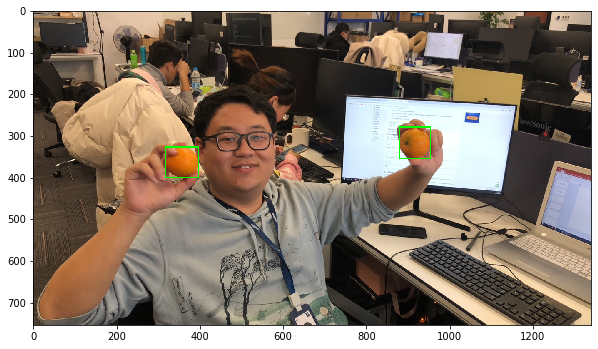

In [691]:
show = image.copy()
for obj in objs:
    cv2.rectangle(show, obj.itl, obj.irb, (0, 255, 0), 2)
plt.figure(figsize=(10, 10))
plt.imshow(show[..., ::-1])

### MTCNN的3分类
* 1. 正类，类别为1，要求目标的IoU>0.7，参与回归和分类
* 2. 负类，类别为0，要求扣取的区域，对每一个目标的IoU<0.4，不参与回归
* 3. 不正不负，类别为-1，要求目标的0.4 < IoU < 0.7，他不参与类别判断，但是参与回归

# 定义样本采集函数和相关方法

In [693]:
np.random.random() # 0 -1

0.26643755532182356

In [696]:
min_value = 10
max_value = 100
# 返回一个随机数，要求，范围是最小min_value，最大是max_value
value_range = max_value - min_value
np.random.random() * value_range + min_value

89.60533888299202

In [697]:
# 随机缩放box，指定minmax scale的情况下进行，scale指对box宽度高度的比例系数，limit则指定了不能超出的边界
def random_resize_box(obj, min_scale, max_scale, limit_r, limit_b):
    obj = obj.copy()  # 对原图做一份拷贝
    width = obj.width
    height = obj.height

    # 生成min_scale再到max_scale范围内的数据点
    obj.x += width * (np.random.random() * (max_scale - min_scale) + min_scale)
    obj.y += height * (np.random.random() * (max_scale - min_scale) + min_scale)
    obj.r += width * (np.random.random() * (max_scale - min_scale) + min_scale)
    obj.b += height * (np.random.random() * (max_scale - min_scale) + min_scale)

    maxline = max(obj.width, obj.height)  # 找到长边
    # 把图像集变成方框
    cx, cy = obj.center
    obj.x = max(0, min(cx - maxline / 2, limit_r))
    obj.y = max(0, min(cy - maxline / 2, limit_b))
    obj.r = max(0, min(cx + maxline / 2, limit_r))
    obj.b = max(0, min(cy + maxline / 2, limit_b))
    return obj


# 制造正样本，随机objs中抽取一个obj，要求制造的new_obj与obj的iou必须在min max范围内，并且限制其不能超过 width和height
def make_positive(objs, iou_min, iou_max, width, height):
    obj = np.random.choice(objs)  # 随机选一个框
    while True:
        newobj = random_resize_box(obj, -0.5, +0.5, width - 1, height - 1)
        if newobj.width > 0 and newobj.height > 0:
            iou = newobj ^ obj
            if iou_min < iou < iou_max:
                return obj, newobj
        
# 制造负样本，但是必须满足newobj不能与objs中任意一个对象iou超过阈值，同时要求box不能超出边界width和height
def make_negative(objs, iou_threshold, width, height):
    min_size = 32
    max_size = 500  # min(width, height)
    all_ok = False
    
    while not all_ok:
        # 先定box的宽高
        box_width = np.random.random() * (max_size - min_size) + min_size
        box_height = np.random.random() * (max_size - min_size) + min_size

        # 产生新框的坐标
        # x: 0 - (width - box_width)
        # y: 0 - (height - box_height)
        x = np.random.random() * (width - box_width)
        y = np.random.random() * (height - box_height)

        # 产生新框对象
        newobj = BBox(x, y, x + box_width - 1, y + box_height - 1)

        # 取到新框的最长边
        maxline = max(newobj.width, newobj.height)

        # 按照最长边转成方框
        cx, cy = newobj.center
        newobj.x = max(0, min(cx - maxline / 2, width - 1))
        newobj.y = max(0, min(cy - maxline / 2, height - 1))
        newobj.r = max(0, min(cx + maxline / 2, width - 1))
        newobj.b = max(0, min(cy + maxline / 2, height - 1))

        # 验证是否符合条件
        all_ok = True
        for obj in objs:  # 将新样本和原样本挨个进行比较，都不符合则证明新样本时满足条件的负例样本
            if obj ^ newobj >= iou_threshold:  # IoU大于指定的阈值，说明生成的样本有问题，需要重新生成一个样本
                all_ok = False
                break
    return newobj

# 居中复制到另一个图
def crop_resize_to(src, roi, dst):
    x, y, r, b = roi                           #取出初始框的坐标
    dh, dw = dst.shape[:2]                     #目标框的高宽
    sh, sw = src.shape[:2]                     #原始图的高宽，为后面裁切边界条件做准备
    rh, rw = b - y + 1, r - x + 1              #原始框的高宽
    ws, hs = dw / rw, dh / rh                  #求出两边对应的比例
    s = min(ws, hs)                            #当需要拉伸比例小的边都能融进框内时即可
    new_h, new_w = rh * s, rw * s              #拉伸后的高与宽
    new_x = (dw - new_w) / 2                   #因为是以原点为中心进行拉伸的，所以坐标变换时要取一半
    new_y = (dh - new_h) / 2
    new_r = (dw + new_w) / 2
    new_b = (dh + new_h) / 2 
    lx = int(max(0, min(x+0.5, sw - 1)))       #裁切，把他图像与框的交点坐标算出来，同时设定边界条件
    ly = int(max(0, min(y+0.5, sh - 1)))
    lr = int(max(0, min(r+0.5, sw - 1)))
    lb = int(max(0, min(b+0.5, sh - 1)))
    fina_x = int(max(0, min(new_x - (x - lx) * s + 0.5, dw - 1)))     #通过拉伸把图像的左边在新框里表示出来
    fina_y = int(max(0, min(new_y - (y - ly) * s + 0.5, dh - 1)))
    fina_r = int(max(0, min(new_r - (r - lr) * s + 0.5, dw - 1)))
    fina_b = int(max(0, min(new_b - (b - lb) * s + 0.5, dh - 1)))
    cv2.resize(src[ly:lb+1, lx:lr+1], (fina_r-fina_x+1, fina_b-fina_y+1), dst=dst[fina_y:fina_b+1, fina_x:fina_r+1])   #比例拉伸

### 制造一个负样本框，并且显示看看效果

{526.9835303686345, 191.84327924923468, 1018.2656599353709, 683.125408815971}

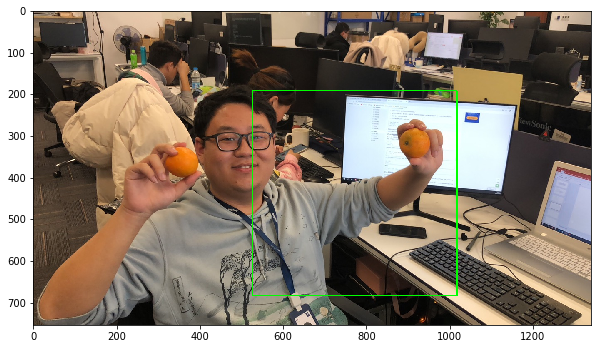

In [593]:
newobj = make_negative(objs, 0.5, image.shape[1], image.shape[0])
show = image.copy()
cv2.rectangle(show, newobj.itl, newobj.irb, (0, 255, 0), 2)
#cv2.rectangle(show, obj.itl, obj.irb, (0, 0, 255), 5)
plt.figure(figsize=(10, 10))
plt.imshow(show[..., ::-1])
newobj

### 把负样本框给复制到一个32x32图像上查看

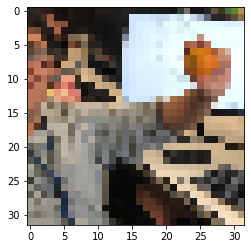

In [594]:
dst = np.zeros((32, 32, 3), dtype=np.uint8)
crop_resize_to(image, newobj.locations(), dst)
plt.imshow(dst[..., ::-1])

### 制造一个正样本，并在图像上显示效果看看

({880, 278, 954, 353},
 {881.9655118047664, 279.49982925274173, 939.8132506895178, 337.3475681374931})

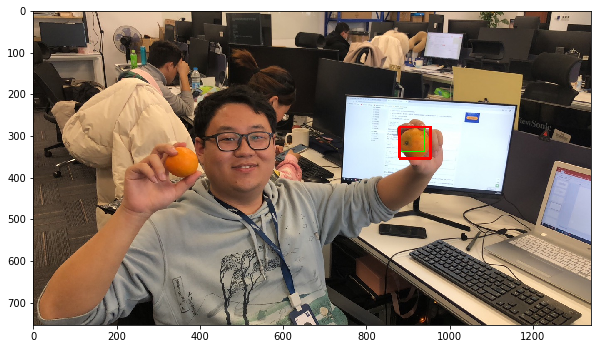

In [595]:
obj, newobj = make_positive(objs, 0.6, 0.9, image.shape[1], image.shape[0])
show = image.copy()
cv2.rectangle(show, newobj.itl, newobj.irb, (0, 255, 0), 2)
cv2.rectangle(show, obj.itl, obj.irb, (0, 0, 255), 5)
plt.figure(figsize=(10, 10))
plt.imshow(show[..., ::-1])
obj, newobj

### 制造正样本2000张，类别为1

In [596]:
num_positive = 2000
directory = "32x32_positive"
for i in range(num_positive):
    image, objs = pairs[np.random.randint(len(pairs)-1)]
    obj, newobj = make_positive(objs, 0.7, 1.0, image.shape[1], image.shape[0])
    small_image = np.zeros((32, 32, 3), dtype=np.uint8)
    crop_resize_to(image, newobj.locations(), small_image)
    cv2.imwrite(f"{directory}/pos_{i:05d}.jpg", small_image)
    
    info = {
        "x": (obj.x - newobj.x) / newobj.width,
        "y": (obj.y - newobj.y) / newobj.height,
        "r": (obj.r - newobj.r) / newobj.width,
        "b": (obj.b - newobj.b) / newobj.height
    }
    with open(f"{directory}/pos_{i:05d}.json", "w") as f:
        f.write(json.dumps(info))

### 制造负样本8000张，类别为0

In [597]:
num_negative = 8000
directory = "32x32_negative"
for i in range(num_negative):
    image, objs = pairs[np.random.randint(len(pairs)-1)]
    newobj = make_negative(objs, 0.4, image.shape[1], image.shape[0])
    small_image = np.zeros((32, 32, 3), dtype=np.uint8)
    crop_resize_to(image, newobj.locations(), small_image)
    cv2.imwrite(f"{directory}/neg_{i:05d}.jpg", small_image)

### 制造回归样本，即类别为-1的，只参与回归不参与分类的样本2000张

In [598]:
num_regression = 2000
directory = "32x32_regression"
for i in range(num_regression):
    image, objs = pairs[np.random.randint(len(pairs)-1)]
    obj, newobj = make_positive(objs, 0.4, 0.7, image.shape[1], image.shape[0])
    small_image = np.zeros((32, 32, 3), dtype=np.uint8)
    crop_resize_to(image, newobj.locations(), small_image)
    cv2.imwrite(f"{directory}/reg_{i:05d}.jpg", small_image)
    
    info = {
        "x": (obj.x - newobj.x) / newobj.width,
        "y": (obj.y - newobj.y) / newobj.height,
        "r": (obj.r - newobj.r) / newobj.width,
        "b": (obj.b - newobj.b) / newobj.height
    }
    with open(f"{directory}/reg_{i:05d}.json", "w") as f:
        f.write(json.dumps(info))

### 开始进入训练

In [599]:
import torch
import torch.nn as nn
import torch.utils.data
from torch.utils.data.sampler import WeightedRandomSampler
import torchvision.transforms.functional as F

In [600]:
class Sigmoid(nn.Module):
    def forward(self, x):
        return torch.sigmoid(x)

# 定义CBA，即conv + bn + activation
class CBAModule(nn.Module):
    def __init__(self, inchannel, outchannel=24, kernel_size=3, stride=1, padding=0, bias=True):
        super(CBAModule, self).__init__()
        self.conv = nn.Conv2d(inchannel, outchannel, kernel_size, stride, padding=padding, bias=bias)
        self.bn = nn.BatchNorm2d(outchannel)
        self.act = nn.ReLU()
    
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x

# 定义模型结构，咱们称之为MNet
class MNet(nn.Module):
    def __init__(self):
        super(MNet, self).__init__()

        self.backbone = torch.nn.Sequential(
            CBAModule(3, 16, 5, stride=1), # 32 - 4 = 28
            torch.nn.MaxPool2d(2, 2), # 14
            CBAModule(16, 32, 3, stride=1), # 14 - 2 = 12
            CBAModule(32, 64, 3, stride=1), # 12 - 2 = 10
            CBAModule(64, 32, 3, stride=1), # 10 - 2 = 8
            torch.nn.MaxPool2d(2, 2), # 2   # 4
            CBAModule(32, 32, 3, stride=1), # 4 - 2 = 2
            CBAModule(32, 32, 2, stride=1), # 1
        )
        self.conf = torch.nn.Conv2d(32, 2, 1, stride=1)
        self.bbox = torch.nn.Conv2d(32, 4, 1, stride=1)
        
        # 对head的权重初始化为0和-2.5，bbox初始化为0
        self.conf.weight.data = torch.zeros(self.conf.weight.shape)
        self.conf.bias.data = torch.ones(self.conf.bias.shape) * -2.5
        self.bbox.weight.data = torch.zeros(self.bbox.weight.shape)
        self.bbox.bias.data = torch.zeros(self.bbox.bias.shape)

    def forward(self, x):
        x = self.backbone(x)
        conf = self.conf(x)
        bbox = self.bbox(x)
        return conf, bbox
    
# 定义dataset，实现3类数据的加载和整合，并且提供weights，即数据抓取的权重，保证样本的平衡性
class Dataset:
    def __init__(self, positive_directory, negative_directory, regression_directory):
        self.positive_directory = positive_directory
        self.negative_directory = negative_directory
        self.regression_directory = regression_directory
        self.positive_samples = self.load_positive_samples(self.positive_directory)
        self.negative_samples = self.load_negative_samples(self.negative_directory)
        self.regression_samples = self.load_regression_samples(self.regression_directory)
        self.samples = self.positive_samples + self.negative_samples + self.regression_samples
        self.weights = np.array([0.33] * len(self.positive_samples) + [0.33] * len(self.negative_samples) + [0.33] * len(self.regression_samples))
        
    # 加载正样本，具有regression，这里label给的是1
    def load_positive_samples(self, directory):
        files = os.listdir(directory)
        files = [f"{directory}/{file}" for file in files if file.endswith(".jpg")]
        samples = []
        for file in files:
            json_file = file[:-3] + "json"
            with open(json_file, "r") as f:
                info = json.loads(f.read())
                samples.append([file, np.array([info["x"], info["y"], info["r"], info["b"]], dtype=np.float32), 1])
        return samples
    
    # 加载回归样本，具有regression，这里label给的是-1
    def load_regression_samples(self, directory):
        files = os.listdir(directory)
        files = [f"{directory}/{file}" for file in files if file.endswith(".jpg")]
        samples = []
        for file in files:
            json_file = file[:-3] + "json"
            with open(json_file, "r") as f:
                info = json.loads(f.read())
                samples.append([file, np.array([info["x"], info["y"], info["r"], info["b"]], dtype=np.float32), -1])
        return samples
        
    # 加载负样本，没有regression，这里label给的是0
    def load_negative_samples(self, directory):
        return [[f"{directory}/{file}", np.array([0, 0, 0, 0], dtype=np.float32), 0] for file in os.listdir(directory) if file.endswith(".jpg")]
    
    # 对于getitem，咱们返回label的同时也返回onehot（0和1有onehot）
    def __getitem__(self, index):
        file, offset, label = self.samples[index]
        onehot = np.array([0, 0], dtype=np.float32)
        if label != -1:
            onehot[label] = 1
        return F.to_tensor(cv2.imread(file)), torch.tensor(offset, dtype=torch.float32), onehot, label
    
    def __len__(self):
        return len(self.samples)

### 构建dataset和model，然后进行训练，这里使用了基于权重的随机采样器，使得采集来的样本是按照权重分配的
### 咱们预期对0、1、-1样本，使用1:2:1的比例

In [601]:
dataset = Dataset("32x32_positive", "32x32_negative", "32x32_regression")
dataloader = torch.utils.data.DataLoader(dataset, sampler=WeightedRandomSampler(dataset.weights, len(dataset.weights)), batch_size=32, num_workers=32)

glr = 1e-2

# 定义模型，移到GPU上
model = MNet().cuda()

#keep_layers = ["layer1", "layer2", "layer3", "layer4"]
#_ = [model.bb._modules[item].register_forward_hook(HookClass(item, recver)) for item in keep_layers]
optim = torch.optim.Adam(model.parameters(), glr)

lr_schedule = {
    5 : 1e-3,
    8 : 1e-4
}

In [602]:
# 开始训练
model.train()
for i in range(10):
    
    if i in lr_schedule:
        glr = lr_schedule[i]
        # 不同的layer有不同的学习率
        for param_group in optim.param_groups:
            param_group['lr'] = glr
    
    for batch_index, (images, offsets, onehots, labels) in enumerate(dataloader):
        images = images.cuda()
        offsets = offsets.cuda()
        onehots = onehots.cuda()
        batch = images.shape[0]
        conf, bbox = model(images)
        conf = conf.view(-1, 2)
        bbox = bbox.view(-1, 4)
        conf = torch.softmax(conf, dim=1)

        # 是否为对象的损失，分类损失
        loss_objectness = 0
        # 回归的损失，偏移量误差的损失
        loss_regression = 0
        
        # 对于不同的label具有不同的处理方式
        for b in range(batch):
            # 对分类loss做贡献，类别设计0和1的
            if labels[b] != -1:
                loss_objectness += -torch.sum(onehots[b] * torch.log(conf[b]))

            # 对误差回归loss做贡献，类别是1和-1的
            if labels[b] != 0:
                loss_regression += torch.sum((bbox[b] - offsets[b]) ** 2)
        
        # 定义objectness和regression损失，为了使得回归效果更好，咱们加强regression的权重
        loss_objectness = loss_objectness / batch
        loss_regression = loss_regression / batch * 5
        # 对于不同的label有不同的处理方式
        loss = loss_objectness + loss_regression

        optim.zero_grad()
        loss.backward()
        optim.step()
    print("Epoch: {}, Lr: {:g}, Loss: {:.5f}, Objectness: {:.5f}, Regression: {:.5f}".format(i, glr, loss.item(), loss_objectness.item(), loss_regression.item()))


Epoch: 0, Lr: 0.01, Loss: 0.09365, Objectness: 0.03827, Regression: 0.05538
Epoch: 1, Lr: 0.01, Loss: 0.04952, Objectness: 0.00681, Regression: 0.04271
Epoch: 2, Lr: 0.01, Loss: 0.05657, Objectness: 0.00670, Regression: 0.04987
Epoch: 3, Lr: 0.01, Loss: 0.02631, Objectness: 0.00640, Regression: 0.01991
Epoch: 4, Lr: 0.01, Loss: 0.16364, Objectness: 0.09990, Regression: 0.06374
Epoch: 5, Lr: 0.001, Loss: 0.01480, Objectness: 0.00065, Regression: 0.01415
Epoch: 6, Lr: 0.001, Loss: 0.01284, Objectness: 0.00363, Regression: 0.00921
Epoch: 7, Lr: 0.001, Loss: 0.01573, Objectness: 0.00206, Regression: 0.01367
Epoch: 8, Lr: 0.0001, Loss: 0.02218, Objectness: 0.00135, Regression: 0.02083
Epoch: 9, Lr: 0.0001, Loss: 0.01111, Objectness: 0.00121, Regression: 0.00990


In [667]:
image = cv2.imread("test.jpg")

### 由于咱们没有写多尺度的代码，所以先处理一个尺度，通过先验知识选择一个有效的尺度

In [668]:
scale = 32 / 330
image_resize = cv2.resize(image, (0, 0), fx=scale, fy=scale)
image_resize.shape

(184, 104, 3)

### 将图像转换为tensor，然后增加一个batch维度并复制到gpu上去，cuda

In [669]:
image_tensor = F.to_tensor(image_resize)[None].cuda()
image_tensor.shape

torch.Size([1, 3, 184, 104])

### 模型评估阶段，进入评估模式，然后进行推理

In [670]:
model.eval()

with torch.no_grad():
    conf, bbox = model(image_tensor)

### 对预测结果进行softmax

In [671]:
conf_prob = torch.softmax(conf, dim=1)
conf_prob.shape

torch.Size([1, 2, 39, 19])

### 对概率值，转换为numpy

In [672]:
conf_np = conf_prob[0, 1].cpu().data.numpy()
conf_np.shape

(39, 19)

### 显示概率值的featuremap 可视化效果

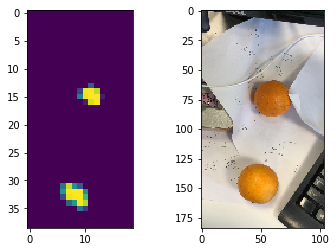

In [673]:
plt.subplot(1, 2, 1)
plt.imshow(conf_np)
plt.subplot(1, 2, 2)
plt.imshow(image_resize[..., ::-1])

### 选择置信度大于0.7的部分

In [674]:
ys, xs = np.where(conf_np > 0.7)

### 把box回归的结果，转换为numpy

In [675]:
bbox_np = bbox[0].cpu().data.numpy()
bbox_np.shape

(4, 39, 19)

### 对回归的结果进行复原，恢复到图像尺度

In [676]:
cell_size = 32
stride = 4
objs = []
for y, x in zip(ys, xs):
    regx = bbox_np[0, y, x]
    regy = bbox_np[1, y, x]
    regr = bbox_np[2, y, x]
    regb = bbox_np[3, y, x]
    cell_x = x * stride
    cell_y = y * stride
    cell_r = cell_x + cell_size
    cell_b = cell_y + cell_size
    ux = (cell_x + regx * cell_size)
    uy = (cell_y + regy * cell_size)
    ur = (cell_r + regr * cell_size)
    ub = (cell_b + regb * cell_size)
    score = conf_np[y, x]
    objs.append(BBox(ux, uy, ur, ub, score))

### 定义nms函数

In [677]:
def nms(objs, iou_threshold):
    
    objs = sorted(objs, key=lambda x:x.score, reverse = True) #将score从大到小排序
    marks = [False] * len(objs)
    needs = []
    
    for i in range(len(objs)):
        if marks[i]:
            continue                                        #自动跳过被标记为False的值
        
        first_box = objs[i]
        needs.append(first_box)
        
        for j in range(i+1,len(objs)):                     #取出相交的框
            if marks[j]:
                continue
                
            second_box = objs[j]
            iou = first_box ^ second_box                  #计算两个框的IoU
            
            if iou > iou_threshold:
                marks[j] = True                           #去重重叠值较高的框
    return needs

### 对目标结果进行nms

In [678]:
keeps = nms(objs, 0.3)

### 显示最终效果

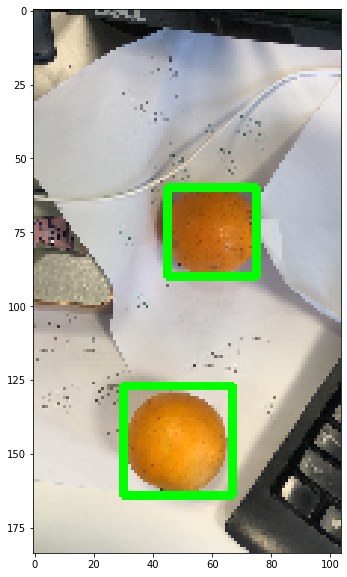

In [679]:
show = image_resize.copy()
for obj in keeps:
    cv2.rectangle(show, obj.itl, obj.irb, (0, 255, 0), 2)
plt.figure(figsize=(10, 10))
plt.imshow(show[..., ::-1])